### Content Based Filtering을 이용한 Airbnb Host Recommender

#### Big Data Group 17. 서현종, 김상현, 김승엽

### 시나리오

Airbnb 신규 Host인 Ernest는 뉴욕에 위치한 자신의 집을 숙박 업소로 공개하고자 한다.  
그러나, Ernest는 위치, 방의 개수, 침대 개수, 침대의 타입, 집기구등  
자신이 소유한 집의 정보만을 알고 있다.  
  
Ernest는 이 집을 Airbnb로 공개하였을때 얼마의 가격을 선정해야 적정한지 궁금하다.  
그는 적절한 가격 책정이 곧 host의 경쟁력 확보와 유의미한 평점을 받을 수 있다고 생각한다.  
여기서 유의미한 평점이란 - 적어도 평균 이상의 평점을 의미한다.  
  
그는 자신과 비슷한 입지와 조건, 집기구를 가진 host가 얼마의 가격을 산정했는지가 필요하다.  
따라서 Ernest는 CAUSWE Big Data 17조가 만든 Content Based Filtering 추천 시스템을 이용하여  
적절한 가격 책정에 대해 도움을 얻고자 한다.

### 프로그램 개요

Airbnb Open Data는 Host 숙소에 대한 106가지의 Feature가 정의되어 있는 데이터 셋이다.  
통상적인 추천 시스템이라면 협업 필터링 (Collaborate Filtering)을 사용하나,  
이 데이터 셋은 평가자인 사용자의 정보가 없기 때문에,  
Content의 정보에 기반하여 추천 시스템이 적합해보였다.  
  
Content Based Filtering을 토대로 이 추천시스템은 호스트가 입력한 숙박 업소의 정보를  
어느 데이터와 유사한지 판별하여 (cos sim), Top N을 추려낸다음,  
각각의 가중치(유사도)와 가격을 곱하여 평균을 내어 적절한 가격을 산정할 것이다.

### 모델 평가방법

#### 미래의 Dataset을 이용한 Heurisitic 한 평가방법

추천 시스템의 가장 기본적이고 효율적인 평가방법은 실제 출시되고 나서의 Heuristic한 평가이다.
  
현재 데이터셋은 2020년도의 데이터로, 이 추천 시스템을 사용하는 Host, Ernest는 2020년에  
이 추천 시스템을 사용하였다고 가정하자. 그렇다면 이 추천 시스템이 유의미하다면  
다음 해인 2021년에 유의미하게 높은 평점을 받아야 할 것이다.  
  
따라서 본 모델을 평가하기 위해 우리는 2020년에서 산출한 추천 정보와 2021년 데이터 셋 사이에서  
가장 유사도가 높은 데이터를 선별한 후, 이 데이터의 평점이 유의미하게 높은지 판별하여  
모델의 정확도를 평가할 것이다.
  
즉, 실제 이 추천 시스템을 토대로 가격을 설정했을시 내년에 얼마나 높은 평점을 받았는지가  
이 모델의 정확도 측정의 관건인 것이다.

## 0. 모델에 사용할 데이터셋 불러오기

In [1]:
from IPython.core.interactiveshell import InteractiveShell #python의 대화형 쉘, 인터프리터
InteractiveShell.ast_node_interactivity = "all"#모든 출력값을 연속적으로 출력
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

In [2]:
abm =  pd.read_csv('../input/airbnb-new-york-city-with-106-features/airbnbmark1.csv')
abm.head(3)
print('abm.shape',abm.shape)
print('abm.size',abm.size)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,...,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20200212052319,2020-02-12,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,...,2020-02-12,48,5,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20200212052319,2020-02-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,"You will have the private, exclusive use of an...","We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,...,2020-02-13,307,70,2014-09-30,2020-02-08,90.0,9.0,9.0,10.0,9.0,10.0,9.0,f,NaN,NaN,f,f,moderate,f,f,1,1,0,0,4.69
2,5099,https://www.airbnb.com/rooms/5099,20200212052319,2020-02-12,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,Read My Full Listing For All Information. New ...,From the apartment is a 10 minute walk to Gran...,I will meet you upon arrival.,I usually check in with guests via text or ema...,• Check-in time is 2PM. • Check-out time is 12...,NaN,NaN,https://a0.muscache.com/im/pictures/24020910/1...,NaN,7322,https://www.airbnb.com/users/show/7322,Chris,2009-02-02,"New York, New York, United States","I'm an artist, writer, traveler, and a native ...",...,2020-02-12,78,8,2009-04-20,2019-10-13,90.0,10.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,moderate,t,t,1,1,0,0,0.59


abm.shape (153254, 106)
abm.size 16244924


## 1. Data Cleaning

Host가 입력할 수 있는 정보들과 (숙소의 위치, 방 타입, 수용 인원, 침대 개수 등)  
평가 지표로 사용이 가능한 정보들 (평점, 평점 개수)  
그리고 최종적으로 추천되는 정보들 (price)

In [3]:
abm1 = abm[['neighbourhood_group_cleansed', 'property_type', 'room_type'
           ,'accommodates', 'bathrooms', 'bedrooms', 'beds'
           , 'price','review_scores_rating', 'number_of_reviews', 'amenities']]

abm1.shape
abm1.head(3)

(153254, 11)

,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities
0,Manhattan,Apartment,Entire home/apt,1,1.0,0.0,1.0,$225.00,94.0,48,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park..."
1,Brooklyn,Guest suite,Entire home/apt,3,1.0,1.0,4.0,$89.00,90.0,307,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."
2,Manhattan,Apartment,Entire home/apt,2,1.0,1.0,1.0,$200.00,90.0,78,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."


In [4]:
abm1 = abm1.drop_duplicates() #중복된 데이터 행 삭제
print('abm1.shape after dropping duplicate rows: ',abm1.shape)
print('abm1.size:  ',abm1.size)
print('DataTypes wise size: \n', abm1.dtypes.value_counts())

abm1.shape after dropping duplicate rows:  (93309, 11)
abm1.size:   1026399
DataTypes wise size: 
 object     5
float64    4
int64      2
dtype: int64


### 결측값 검사, Data Cleaning

In [5]:
abm1.replace((' '),np.nan,inplace=True) #inplace가 T면 새로운 return 값이 아닌 원본을 아예 수정
abm1.isnull().sum()

neighbourhood_group_cleansed        0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          67
bedrooms                          143
beds                              735
price                               0
review_scores_rating            16377
number_of_reviews                   0
amenities                           0
dtype: int64

In [6]:
abm1 = abm1.dropna(subset=['review_scores_rating'], how='any', axis=0)
abm1 = abm1.fillna(0)
abm1.isnull().sum()
print('abm1.shape after dropping nan rows: ',abm1.shape)

neighbourhood_group_cleansed    0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
price                           0
review_scores_rating            0
number_of_reviews               0
amenities                       0
dtype: int64

abm1.shape after dropping nan rows:  (76932, 11)


In [7]:
def clean_data(df): #$표시 떼어내기. ,구분표 없애기
    for i in ['price',]:
        df[i]=df[i].str.replace('$','').str.replace(',', '').astype(float)
    
    df.replace('', np.nan, inplace=True)
    
    return df.head(2)
clean_data(abm1)

,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities
0,Manhattan,Apartment,Entire home/apt,1,1.0,0.0,1.0,225.0,94.0,48,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park..."
1,Brooklyn,Guest suite,Entire home/apt,3,1.0,1.0,4.0,89.0,90.0,307,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."


### 정확도를 위해 리뷰 개수 5개 미만인 호스트는 삭제
리뷰 개수가 소수이면서 비정상적으로 평점이 높은 허수 데이터들을 절삭한다.  

In [8]:
indexNames = abm1[abm1['number_of_reviews'] < 5].index
abm1.drop(indexNames , inplace=True)
abm1.shape

(57457, 11)

### Neighbourhood를 onehot encoding 하기

In [9]:
abm1['neighbourhood_group_cleansed'].value_counts()

Brooklyn         23708
Manhattan        23175
Queens            8202
Bronx             1757
Staten Island      615
Name: neighbourhood_group_cleansed, dtype: int64

In [10]:
abm1.loc[abm1['neighbourhood_group_cleansed'].str.contains('Brooklyn'), 'Brooklyn'] = 1
abm1.loc[abm1['neighbourhood_group_cleansed'].str.contains('Manhattan'), 'Manhattan'] = 1
abm1.loc[abm1['neighbourhood_group_cleansed'].str.contains('Queens'), 'Queens'] = 1
abm1.loc[abm1['neighbourhood_group_cleansed'].str.contains('Bronx'), 'Bronx'] = 1
abm1.loc[abm1['neighbourhood_group_cleansed'].str.contains('Staten Island'), 'Staten Island'] = 1

abm1 = abm1.fillna(0)

abm1.drop('neighbourhood_group_cleansed', axis = 1, inplace=True)
abm1.isnull().sum()
abm1.head(5)

property_type           0
room_type               0
accommodates            0
bathrooms               0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
amenities               0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
dtype: int64

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island
0,Apartment,Entire home/apt,1,1.0,0.0,1.0,225.0,94.0,48,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",0.0,1.0,0.0,0.0,0.0
1,Guest suite,Entire home/apt,3,1.0,1.0,4.0,89.0,90.0,307,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.0,0.0,0.0,0.0,0.0
2,Apartment,Entire home/apt,2,1.0,1.0,1.0,200.0,90.0,78,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,1.0,0.0,0.0,0.0
3,Apartment,Private room,2,0.0,1.0,1.0,60.0,90.0,50,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",1.0,0.0,0.0,0.0,0.0
4,Apartment,Private room,2,1.0,1.0,1.0,79.0,84.0,463,"{TV,Wifi,""Air conditioning"",""Paid parking off ...",0.0,1.0,0.0,0.0,0.0


### Property type을 onehot encoding 하기

In [11]:
# property_type에는 무슨 값이 있을지
abm1['property_type'].value_counts()

Apartment             42767
House                  6003
Townhouse              2724
Condominium            1946
Loft                   1899
Guest suite             813
Boutique hotel          267
Hotel                   260
Serviced apartment      227
Hostel                  110
Guesthouse              102
Bed and breakfast        54
Other                    51
Bungalow                 49
Villa                    42
Tiny house               34
Camper/RV                34
Resort                   20
Cottage                  18
Boat                     10
Earth house               8
Tent                      4
Aparthotel                4
Cabin                     3
Houseboat                 3
Barn                      3
Castle                    2
Name: property_type, dtype: int64

In [12]:
Mod_prop_type=abm1['property_type'].value_counts()[5:len(abm1['property_type'].value_counts())].index.tolist()

def change_prop_type(label):
    if label in Mod_prop_type:
        label='Other'
    return label

In [13]:
abm1.loc[:,'property_type'] = abm1.loc[:,'property_type'].apply(change_prop_type)

In [14]:
abm1['property_type'].value_counts() # 5순위 이하 주거형태는 Others로 분류

Apartment      42767
House           6003
Townhouse       2724
Other           2118
Condominium     1946
Loft            1899
Name: property_type, dtype: int64

In [15]:
abm1.loc[abm1['property_type'].str.contains('Apartment'), 'Apartment'] = 1
abm1.loc[abm1['property_type'].str.contains('House'), 'House'] = 1
abm1.loc[abm1['property_type'].str.contains('Other'), 'Other'] = 1
abm1.loc[abm1['property_type'].str.contains('Townhouse'), 'Townhouse'] = 1
abm1.loc[abm1['property_type'].str.contains('Condominium'), 'Condominium'] = 1
abm1.loc[abm1['property_type'].str.contains('Loft'), 'Loft'] = 1
abm1 = abm1.fillna(0)

abm1.isnull().sum()
abm1.head(5)

property_type           0
room_type               0
accommodates            0
bathrooms               0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
amenities               0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
Apartment               0
House                   0
Other                   0
Townhouse               0
Condominium             0
Loft                    0
dtype: int64

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft
0,Apartment,Entire home/apt,1,1.0,0.0,1.0,225.0,94.0,48,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Other,Entire home/apt,3,1.0,1.0,4.0,89.0,90.0,307,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Apartment,Entire home/apt,2,1.0,1.0,1.0,200.0,90.0,78,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Apartment,Private room,2,0.0,1.0,1.0,60.0,90.0,50,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Apartment,Private room,2,1.0,1.0,1.0,79.0,84.0,463,"{TV,Wifi,""Air conditioning"",""Paid parking off ...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
abm1.drop('property_type', axis = 1, inplace=True)
abm1.head(3)

,room_type,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft
0,Entire home/apt,1,1.0,0.0,1.0,225.0,94.0,48,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Entire home/apt,3,1.0,1.0,4.0,89.0,90.0,307,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Entire home/apt,2,1.0,1.0,1.0,200.0,90.0,78,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Room_type를 one hot encoding 하기

In [17]:
abm1['room_type'].value_counts()

Entire home/apt    31050
Private room       24844
Shared room         1121
Hotel room           442
Name: room_type, dtype: int64

In [18]:
abm1.loc[abm1['room_type'].str.contains('Entire home/apt'), 'Entire home/apt'] = 1
abm1.loc[abm1['room_type'].str.contains('Private room'), 'Private room'] = 1
abm1.loc[abm1['room_type'].str.contains('Shared room'), 'Shared room'] = 1
abm1.loc[abm1['room_type'].str.contains('Hotel room'), 'Hotel room'] = 1
abm1 = abm1.fillna(0)

abm1.drop('room_type', axis = 1, inplace=True)
abm1.isnull().sum()
abm1.head(5)

accommodates            0
bathrooms               0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
amenities               0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
Apartment               0
House                   0
Other                   0
Townhouse               0
Condominium             0
Loft                    0
Entire home/apt         0
Private room            0
Shared room             0
Hotel room              0
dtype: int64

,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room
0,1,1.0,0.0,1.0,225.0,94.0,48,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3,1.0,1.0,4.0,89.0,90.0,307,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,1.0,1.0,1.0,200.0,90.0,78,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,0.0,1.0,1.0,60.0,90.0,50,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,1.0,1.0,1.0,79.0,84.0,463,"{TV,Wifi,""Air conditioning"",""Paid parking off ...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Amenities를 column으로 분해하기

In [19]:
# splitting amenities feature 

amenities_list = list(abm1.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
print('\n Number of amenities present in total:',len(amenities_set))
print(sorted(amenities_set))


 Number of amenities present in total: 151
['', '24-hour check-in', 'Accessible-height bed', 'Accessible-height toilet', 'Air conditioning', 'Air purifier', 'BBQ grill', 'Baby bath', 'Baby monitor', 'Babysitter recommendations', 'Baking sheet', 'Barbecue utensils', 'Bath towel', 'Bathrobes', 'Bathroom essentials', 'Bathtub', 'Bathtub with bath chair', 'Beach essentials', 'Beachfront', 'Bed linens', 'Bedroom comforts', 'Bluetooth speaker', 'Body soap', 'Bottled water', 'Bread maker', 'Breakfast', 'Building staff', 'Buzzer/wireless intercom', 'Cable TV', 'Carbon monoxide detector', 'Cat(s)', 'Ceiling hoist', 'Changing table', 'Children’s books and toys', 'Children’s dinnerware', 'Cleaning before checkout', 'Coffee maker', 'Cooking basics', 'Crib', 'Disabled parking spot', 'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman', 'Dryer', 'EV charger', 'Electric profiling bed', 'Elevator', 'Essentials', 'Ethernet connection', 'Extra pillows and blankets', 'Extra space around bed', 'Fam

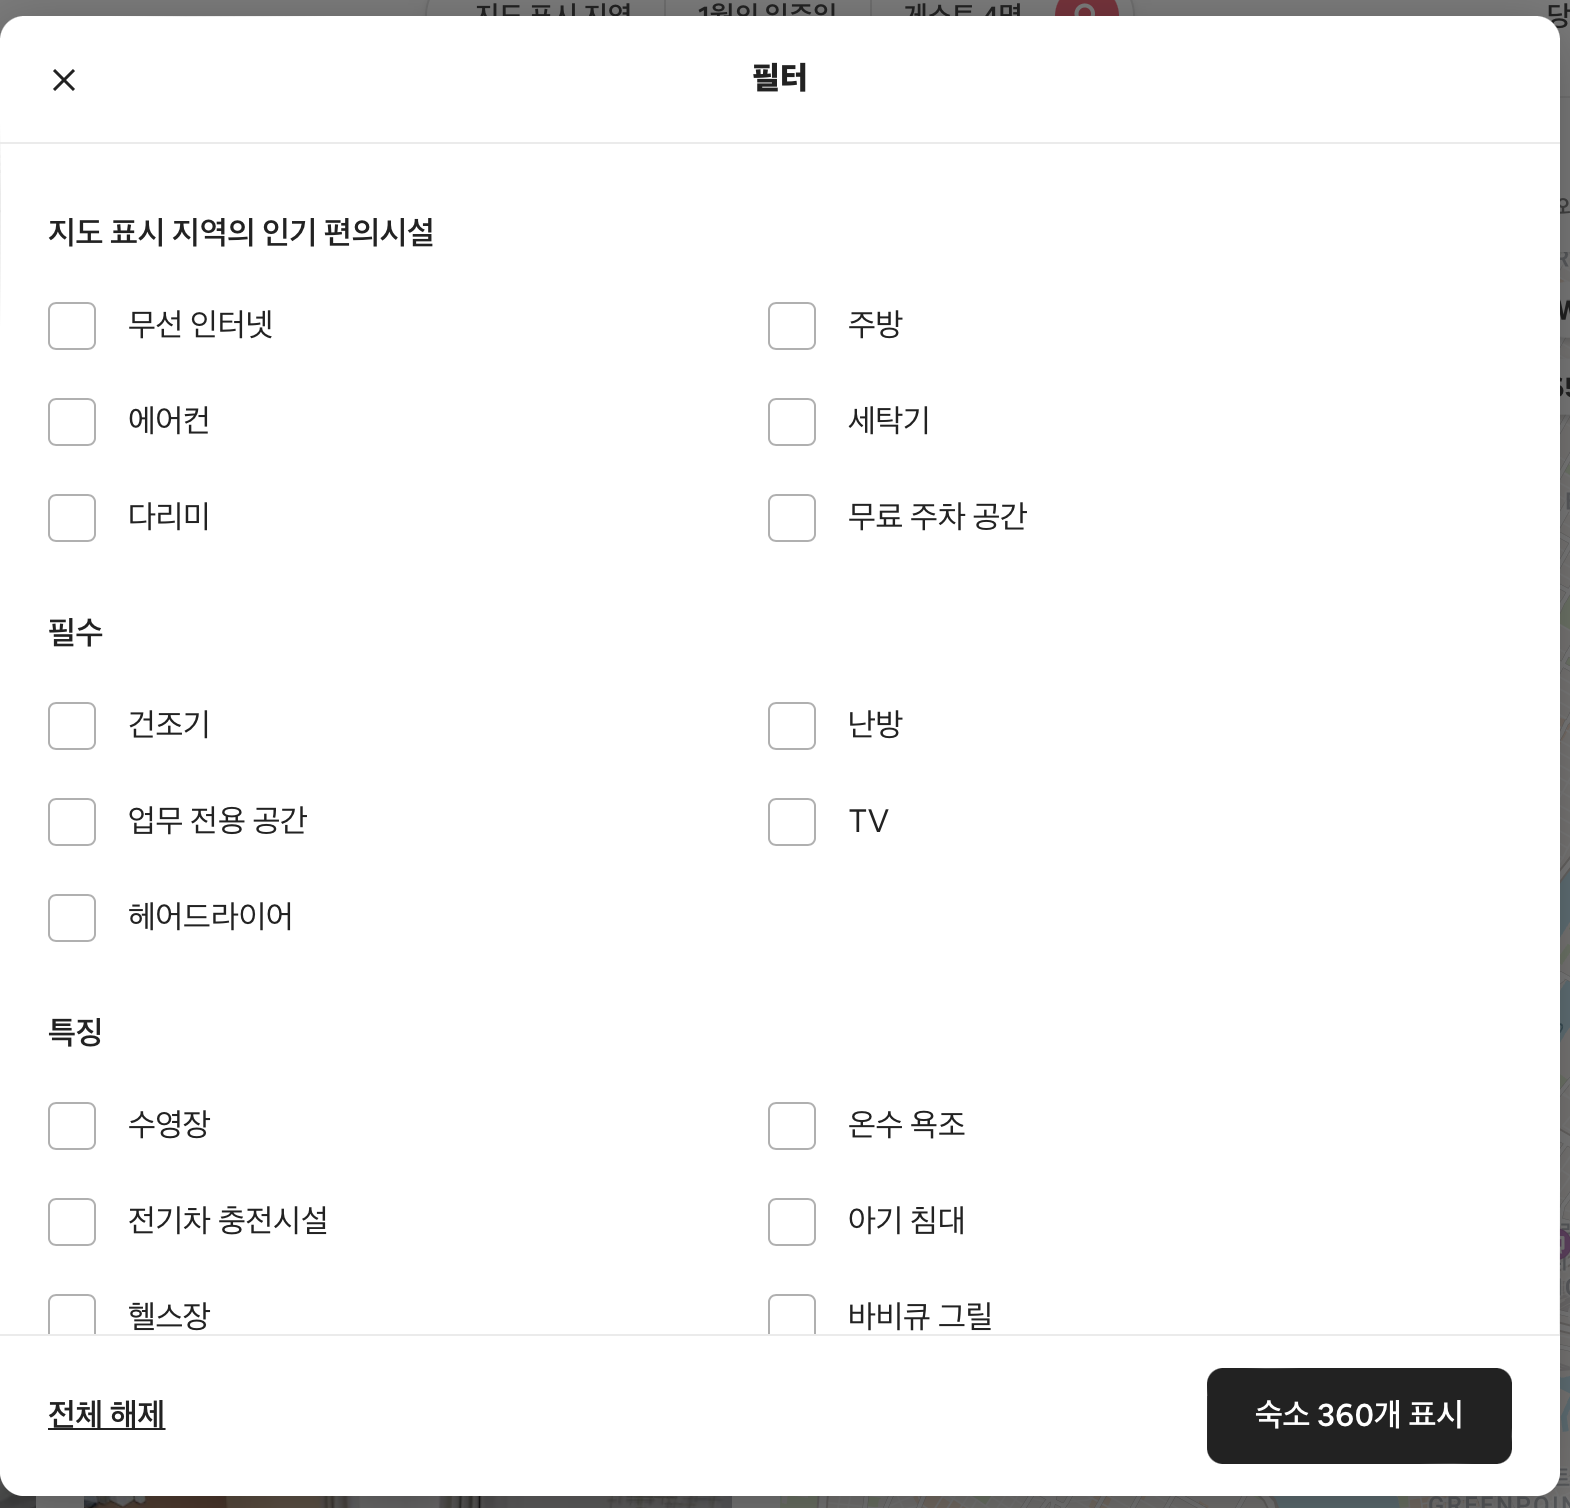

airbnb 홈페이지에서 사용자가 선택 가능한 대표적인 amenities만을 우선적으로 반영하도록 한다.

In [20]:
#직접... 연관된 amenities를 하나의 카테고리화 하여 묶었다.
#그리고 각 amenities에 대해 새로운 컬럼을 추가하였다.
#loc로 행 조회후 컬럼값을 true인 경우 1로 바꿨다.
abm1.loc[abm1['amenities'].str.contains('Wifi|wifi'), 'wireless_internet'] = 1
abm1.loc[abm1['amenities'].str.contains('kitchen|Kitchen|Cooking basics'), 'kitchen'] = 1
abm1.loc[abm1['amenities'].str.contains('Air conditioning'), 'air_conditioning'] = 1
abm1.loc[abm1['amenities'].str.contains('Washer'), 'washer'] = 1
abm1.loc[abm1['amenities'].str.contains('Iron'), 'iron'] = 1
abm1.loc[abm1['amenities'].str.contains('Paid parking off premises|Paid parking on premises|Free parking on premises|Free street parking'), 'parking'] = 1
abm1.loc[abm1['amenities'].str.contains('Dryer'), 'dryer'] = 1
abm1.loc[abm1['amenities'].str.contains('Heating'), 'heating'] = 1
abm1.loc[abm1['amenities'].str.contains('TV|tv'), 'tv'] = 1
abm1.loc[abm1['amenities'].str.contains('Hair dryer'), 'hair_dryer'] = 1

In [21]:
abm1.isnull().sum()

accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
price                       0
review_scores_rating        0
number_of_reviews           0
amenities                   0
Brooklyn                    0
Manhattan                   0
Queens                      0
Bronx                       0
Staten Island               0
Apartment                   0
House                       0
Other                       0
Townhouse                   0
Condominium                 0
Loft                        0
Entire home/apt             0
Private room                0
Shared room                 0
Hotel room                  0
wireless_internet         617
kitchen                  5379
air_conditioning         5740
washer                  36980
iron                    13858
parking                 20013
dryer                   37271
heating                  1444
tv                      16554
hair_dryer              11369
dtype: int

In [22]:
abm1 = abm1.fillna(0)
abm1.drop('amenities', axis = 1, inplace=True)
abm1.isnull().sum()
abm1.head(5)

accommodates            0
bathrooms               0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
Apartment               0
House                   0
Other                   0
Townhouse               0
Condominium             0
Loft                    0
Entire home/apt         0
Private room            0
Shared room             0
Hotel room              0
wireless_internet       0
kitchen                 0
air_conditioning        0
washer                  0
iron                    0
parking                 0
dryer                   0
heating                 0
tv                      0
hair_dryer              0
dtype: int64

,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room,wireless_internet,kitchen,air_conditioning,washer,iron,parking,dryer,heating,tv,hair_dryer
0,1,1.0,0.0,1.0,225.0,94.0,48,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,3,1.0,1.0,4.0,89.0,90.0,307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,200.0,90.0,78,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
3,2,0.0,1.0,1.0,60.0,90.0,50,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,1.0,1.0,1.0,79.0,84.0,463,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


## 2. Content Based Filtering 추천 시스템

### 유사도 검사를 위한 새로운 matrix 생성

In [23]:
abm2 = abm1.drop(['price', 'review_scores_rating', 'number_of_reviews'], axis = 1, inplace=False)
abm2.head(5)

,accommodates,bathrooms,bedrooms,beds,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room,wireless_internet,kitchen,air_conditioning,washer,iron,parking,dryer,heating,tv,hair_dryer
0,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,3,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
3,2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [24]:
abm2_mean = abm2.mean()
abm2_std  = abm2.std()
abm2 = (abm2 - abm2.mean())/abm2.std()
abm2.head(5)

,accommodates,bathrooms,bedrooms,beds,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room,wireless_internet,kitchen,air_conditioning,washer,iron,parking,dryer,heating,tv,hair_dryer
0,-1.040432,-0.336740,-1.547396,-0.544371,-0.838134,1.216240,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,0.922200,-0.872794,-0.141061,-0.088047,0.104187,0.321381,0.333147,-0.744125,0.563778,0.731074,-0.735929,0.160559,0.636166,0.496665
1,-0.065338,-0.336740,-0.283554,1.854489,1.193107,-0.822192,-0.408066,-0.177605,-0.104016,-1.706238,-0.341563,5.111506,-0.223087,-0.187231,-0.184878,0.922200,-0.872794,-0.141061,-0.088047,0.104187,0.321381,0.333147,-0.744125,0.563778,0.731074,-0.735929,0.160559,0.636166,0.496665
2,-0.552885,-0.336740,-0.283554,-0.544371,-0.838134,1.216240,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,0.922200,-0.872794,-0.141061,-0.088047,0.104187,0.321381,0.333147,-0.744125,0.563778,-1.367827,-0.735929,0.160559,0.636166,0.496665
3,-0.552885,-2.787566,-0.283554,-0.544371,1.193107,-0.822192,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,-1.084345,1.145726,-0.141061,-0.088047,0.104187,0.321381,0.333147,-0.744125,-1.773717,-1.367827,-0.735929,0.160559,-1.571891,-2.013395
4,-0.552885,-0.336740,-0.283554,-0.544371,-0.838134,1.216240,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,-1.084345,1.145726,-0.141061,-0.088047,0.104187,-3.111520,0.333147,-0.744125,0.563778,0.731074,-0.735929,0.160559,0.636166,0.496665


### 유사도 계산해보기
코사인 유사도로 계산한다.

In [25]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

abm2.columns #사용자로부터 입력받아야 하는 값들

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'Brooklyn',
       'Manhattan', 'Queens', 'Bronx', 'Staten Island', 'Apartment', 'House',
       'Other', 'Townhouse', 'Condominium', 'Loft', 'Entire home/apt',
       'Private room', 'Shared room', 'Hotel room', 'wireless_internet',
       'kitchen', 'air_conditioning', 'washer', 'iron', 'parking', 'dryer',
       'heating', 'tv', 'hair_dryer'],
      dtype='object')

In [26]:
checklist = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'Borough'
             , 'property_type', 'room_type', 'wireless_internet'
             ,'kitchen', 'air_conditioning', 'washer', 'iron'
             , 'parking', 'dryer','heating', 'tv', 'hair_dryer']

def simple_ui():
    data = []
    for item, idx in zip(checklist, range(len(checklist))):
        if idx <= 3:
            x = int(input(f'\'{item}\' ?: '))
            data.append(x)
        elif idx == 4:
            print('Brooklyn: 0, Manhattan: 1, Queens: 2, Bronx: 3, Staten Island: 4')
            x = int(input('your local?: '))
            if x < 0 and x > 4:
                print('error. wrong input')
                exit(0)
            else:
                for i in range(5):
                  if i == x:
                      data.append(1)
                  else:
                      data.append(0)
        elif idx == 5:
            print('Apartment: 0, House: 1, Other: 2, Townhouse: 3, Condominium: 4, Loft: 5')
            x = int(input('your property type?: '))
            if x < 0 and x > 5:
                print('error. wrong input')
                exit(0)
            else:
                for i in range(6):
                  if i == x:
                      data.append(1)
                  else:
                      data.append(0)
        elif idx == 6:
            print('Entire home/apt: 0, Private room: 1, Shared room: 2, Hotel room: 3')
            x = int(input('your room type?: '))
            if x < 0 and x > 3:
                print('error. wrong input')
                exit(0)
            else:
                for i in range(4):
                  if i == x:
                      data.append(1)
                  else:
                      data.append(0)
        elif idx >= 7:
            x = int(input(f'Do you have/support any \'{item}\'? (t/f: 1/0): '))
            if x < 0 and x > 1:
                print('error. wrong input')
                exit(0)
            data.append(x)
    return np.array(data)

def norm_input(test, pool, columns):
    result = []
    idx = 0
    for item in columns:
        result.append((test[idx] - pool[item].mean())/pool[item].std())
        idx += 1
    return result
        
data = simple_ui().astype(float)
print(data)

'accommodates' ?:  2
'bathrooms' ?:  1
'bedrooms' ?:  1
'beds' ?:  1


Brooklyn: 0, Manhattan: 1, Queens: 2, Bronx: 3, Staten Island: 4


your local?:  0


Apartment: 0, House: 1, Other: 2, Townhouse: 3, Condominium: 4, Loft: 5


your property type?:  0


Entire home/apt: 0, Private room: 1, Shared room: 2, Hotel room: 3


your room type?:  0
Do you have/support any 'wireless_internet'? (t/f: 1/0):  1
Do you have/support any 'kitchen'? (t/f: 1/0):  1
Do you have/support any 'air_conditioning'? (t/f: 1/0):  1
Do you have/support any 'washer'? (t/f: 1/0):  0
Do you have/support any 'iron'? (t/f: 1/0):  0
Do you have/support any 'parking'? (t/f: 1/0):  0
Do you have/support any 'dryer'? (t/f: 1/0):  1
Do you have/support any 'heating'? (t/f: 1/0):  1
Do you have/support any 'tv'? (t/f: 1/0):  1
Do you have/support any 'hair_dryer'? (t/f: 1/0):  1


[2. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 1.]


In [27]:
sim = []
nd = norm_input(data, abm1, abm2.columns)

for item in abm2.to_numpy():
    sim.append(cos_sim(nd, item))
    
sim[:10]

[0.027725950861022676,
 -0.005988851956283656,
 0.22556109616892142,
 0.28191093475305984,
 -0.31203577726066345,
 -0.10868046233468515,
 -0.09576188769319664,
 -0.18512009828688875,
 -0.13180110827579897,
 -0.033266718437978016]

In [28]:
sim_sorted_byindex = sorted(range(len(sim)), key=lambda k: sim[k])
sim_sorted_byindex = sim_sorted_byindex[-30:]
print(sim_sorted_byindex)

sim.sort()
sim = sim[-30:]
print(sim)
# 상위 30개의 유사도를 가지는 데이터를 추출

[16579, 17750, 17765, 19545, 27229, 27419, 27944, 31016, 32503, 33837, 34165, 35556, 35808, 36187, 41908, 42291, 48264, 4013, 24166, 30480, 12935, 12946, 16060, 16714, 17025, 17499, 36289, 36963, 50774, 51224]
[0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.8326481742578328, 0.83809619969203, 0.83809619969203, 0.83809619969203, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367, 0.8484539712718367]


### 평균 이상의 평점을 가진것만 추려내기
이제 유사도를 가진 Top 30개의 데이터를 산출하였지만,  
이중에서 유의미하게 평점이 높은 데이터들을 선별해야 한다.  
이를 토대로 산정된 가격이 경쟁력이 있어야함을 뒷받침해야 한다.

In [29]:
mean = 0

for idx in sim_sorted_byindex:
    mean += abm1.to_numpy()[idx][5]

mean = mean / 30
print(mean)

96.8


### 상위 30개의 데이터에서 평점이 평균 이상인 것만 추려내기

In [30]:
selected = {}

for idx, s in zip(sim_sorted_byindex, sim):
    if abm1.to_numpy()[idx][5] > mean:
        selected[idx] = s
        
selected

{17750: 0.8326481742578328,
 17765: 0.8326481742578328,
 19545: 0.8326481742578328,
 27419: 0.8326481742578328,
 31016: 0.8326481742578328,
 32503: 0.8326481742578328,
 33837: 0.8326481742578328,
 35556: 0.8326481742578328,
 35808: 0.8326481742578328,
 36187: 0.8326481742578328,
 41908: 0.8326481742578328,
 42291: 0.8326481742578328,
 48264: 0.8326481742578328,
 30480: 0.83809619969203,
 12935: 0.8484539712718367,
 12946: 0.8484539712718367,
 16714: 0.8484539712718367,
 17025: 0.8484539712718367,
 17499: 0.8484539712718367,
 36963: 0.8484539712718367,
 51224: 0.8484539712718367}

## 3. 최종 추천 가격

In [31]:
def recommend_price(selected):
    child = 0
    parent = 0
    for key in selected.keys():
        child += abm1.to_numpy()[key][4] * selected[key]
        parent += selected[key]
    return child/parent

In [32]:
rp = recommend_price(selected)
print(rp)

153.59590628174533


## 4. 모델 검증
다음 연도, 2021년 에어비앤비 데이터를 가져와 호스트에게 추천한 가격이 경쟁력이 있는지  
판별할 것이다. 추천한 정보와 유사도가 높은 데이터들을 추출하여 평점을 확인해볼것이다.  

In [33]:
tst =  pd.read_csv('../input/airbnb-new-york-listing-data-scraped-nov-3-2021/listings.csv')
tst.head(3)
print('tst.shape',tst.shape)
print('tst.size',tst.size)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,...,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20211102175544,2021-11-03,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,a few days or more,35%,18%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,8.0,8.0,"['email', 'phone', 'reviews', 'offline_governm...",t,...,t,0,17,47,322,2021-11-03,48,0,0,2009-11-21,2019-11-04,4.70,4.72,4.62,4.76,4.79,4.86,4.41,NaN,f,3,3,0,0,0.33
1,3831,https://www.airbnb.com/rooms/3831,20211102175544,2021-11-03,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,a few days or more,21%,76%,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,...,t,4,10,33,220,2021-11-03,408,38,0,2015-01-05,2021-06-29,4.46,4.59,4.50,4.79,4.81,4.72,4.65,NaN,f,1,1,0,0,4.91
2,5121,https://www.airbnb.com/rooms/5121,20211102175544,2021-11-03,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",within a few hours,100%,100%,f,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,...,t,30,60,90,365,2021-11-03,50,0,0,2014-01-22,2016-06-05,4.52,4.22,4.09,4.91,4.91,4.47,4.52,NaN,f,2,0,2,0,0.53


tst.shape (37713, 74)
tst.size 2790762


In [34]:
tst1 = tst[['neighbourhood_group_cleansed', 'property_type', 'room_type'
           ,'accommodates', 'bathrooms_text', 'bedrooms', 'beds'
           , 'price','review_scores_rating', 'number_of_reviews', 'amenities']]

tst1.shape

(37713, 11)

In [35]:
tst1 = tst1.drop_duplicates() #중복된 데이터 행 삭제
tst1.replace((' '),np.nan,inplace=True) #inplace가 T면 새로운 return 값이 아닌 원본을 아예 수정

tst1.isnull().sum()

neighbourhood_group_cleansed       0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_text                   111
bedrooms                        3914
beds                            2220
price                              0
review_scores_rating            8890
number_of_reviews                  0
amenities                          0
dtype: int64

In [36]:
tst1 = tst1.dropna(subset=['review_scores_rating'], how='any', axis=0)
tst1 = tst1.fillna(0)
tst1.isnull().sum()

neighbourhood_group_cleansed    0
property_type                   0
room_type                       0
accommodates                    0
bathrooms_text                  0
bedrooms                        0
beds                            0
price                           0
review_scores_rating            0
number_of_reviews               0
amenities                       0
dtype: int64

In [37]:
clean_data(tst1)
indexNames = tst1[tst1['number_of_reviews'] < 5].index
tst1.drop(indexNames , inplace=True)
tst1.shape

,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities
0,Manhattan,Entire rental unit,Entire home/apt,1,1 bath,0.0,1.0,150.0,4.70,48,"[""Bathtub"", ""Dedicated workspace"", ""Hair dryer..."
1,Brooklyn,Entire guest suite,Entire home/apt,3,1 bath,1.0,3.0,73.0,4.46,408,"[""Microwave"", ""Oven"", ""Pack \u2019n play/Trave..."


(18029, 11)

In [38]:
tst1.loc[tst1['neighbourhood_group_cleansed'].str.contains('Brooklyn'), 'Brooklyn'] = 1
tst1.loc[tst1['neighbourhood_group_cleansed'].str.contains('Manhattan'), 'Manhattan'] = 1
tst1.loc[tst1['neighbourhood_group_cleansed'].str.contains('Queens'), 'Queens'] = 1
tst1.loc[tst1['neighbourhood_group_cleansed'].str.contains('Bronx'), 'Bronx'] = 1
tst1.loc[tst1['neighbourhood_group_cleansed'].str.contains('Staten Island'), 'Staten Island'] = 1

tst1 = tst1.fillna(0)

tst1.drop('neighbourhood_group_cleansed', axis = 1, inplace=True)
tst1.isnull().sum()
tst1.head(5)

property_type           0
room_type               0
accommodates            0
bathrooms_text          0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
amenities               0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
dtype: int64

,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island
0,Entire rental unit,Entire home/apt,1,1 bath,0.0,1.0,150.0,4.70,48,"[""Bathtub"", ""Dedicated workspace"", ""Hair dryer...",0.0,1.0,0.0,0.0,0.0
1,Entire guest suite,Entire home/apt,3,1 bath,1.0,3.0,73.0,4.46,408,"[""Microwave"", ""Oven"", ""Pack \u2019n play/Trave...",1.0,0.0,0.0,0.0,0.0
2,Private room in rental unit,Private room,2,0,1.0,1.0,60.0,4.52,50,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",1.0,0.0,0.0,0.0,0.0
4,Private room in rental unit,Private room,2,1 bath,1.0,1.0,68.0,4.21,505,"[""Conditioner"", ""Drying rack for clothing"", ""H...",0.0,1.0,0.0,0.0,0.0
5,Private room in rental unit,Private room,1,1 shared bath,1.0,1.0,75.0,4.91,118,"[""Paid parking off premises"", ""Hot water"", ""Sh...",0.0,1.0,0.0,0.0,0.0


In [39]:
tst1['property_type'].value_counts()

Entire rental unit                     7763
Private room in rental unit            4804
Private room in residential home       1207
Entire residential home                 735
Entire condominium (condo)              522
Private room in townhouse               470
Entire loft                             396
Entire townhouse                        360
Room in hotel                           294
Entire guest suite                      238
Room in boutique hotel                  211
Private room in condominium (condo)     203
Shared room in rental unit              201
Private room in loft                    145
Entire serviced apartment                72
Private room in guest suite              71
Entire guesthouse                        43
Room in aparthotel                       31
Private room in bed and breakfast        24
Private room in serviced apartment       22
Private room in hostel                   18
Shared room in loft                      17
Entire place                    

In [40]:
tst1.loc[tst1['property_type'].str.contains('rental unit|apartment|aparthotel'), 'Apartment'] = 1
tst1.loc[tst1['property_type'].str.contains('residential home'), 'House'] = 1
tst1['Other'] = 1
tst1.loc[tst1['property_type'].str.contains('townhouse'), 'Townhouse'] = 1
tst1.loc[tst1['property_type'].str.contains('condominium'), 'Condominium'] = 1
tst1.loc[tst1['property_type'].str.contains('loft'), 'Loft'] = 1
tst1 = tst1.fillna(0)

tst1.at[tst1[tst1['Apartment'] == 1].index, 'Other'] = 0
tst1.at[tst1[tst1['House'] == 1].index, 'Other'] = 0
tst1.at[tst1[tst1['Townhouse'] == 1].index, 'Other'] = 0
tst1.at[tst1[tst1['Condominium'] == 1].index, 'Other'] = 0
tst1.at[tst1[tst1['Loft'] == 1].index, 'Other'] = 0

tst1.drop('property_type', axis = 1, inplace=True)
tst1.isnull().sum()
tst1.head(5)

room_type               0
accommodates            0
bathrooms_text          0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
amenities               0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
Apartment               0
House                   0
Other                   0
Townhouse               0
Condominium             0
Loft                    0
dtype: int64

,room_type,accommodates,bathrooms_text,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft
0,Entire home/apt,1,1 bath,0.0,1.0,150.0,4.70,48,"[""Bathtub"", ""Dedicated workspace"", ""Hair dryer...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0
1,Entire home/apt,3,1 bath,1.0,3.0,73.0,4.46,408,"[""Microwave"", ""Oven"", ""Pack \u2019n play/Trave...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0
2,Private room,2,0,1.0,1.0,60.0,4.52,50,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0
4,Private room,2,1 bath,1.0,1.0,68.0,4.21,505,"[""Conditioner"", ""Drying rack for clothing"", ""H...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0
5,Private room,1,1 shared bath,1.0,1.0,75.0,4.91,118,"[""Paid parking off premises"", ""Hot water"", ""Sh...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0


In [41]:
tst1.loc[tst1['room_type'].str.contains('Entire home/apt'), 'Entire home/apt'] = 1
tst1.loc[tst1['room_type'].str.contains('Private room'), 'Private room'] = 1
tst1.loc[tst1['room_type'].str.contains('Shared room'), 'Shared room'] = 1
tst1.loc[tst1['room_type'].str.contains('Hotel room'), 'Hotel room'] = 1
tst1 = tst1.fillna(0)

tst1.drop('room_type', axis = 1, inplace=True)
tst1.isnull().sum()
tst1.head(5)

accommodates            0
bathrooms_text          0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
amenities               0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
Apartment               0
House                   0
Other                   0
Townhouse               0
Condominium             0
Loft                    0
Entire home/apt         0
Private room            0
Shared room             0
Hotel room              0
dtype: int64

,accommodates,bathrooms_text,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room
0,1,1 bath,0.0,1.0,150.0,4.70,48,"[""Bathtub"", ""Dedicated workspace"", ""Hair dryer...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3,1 bath,1.0,3.0,73.0,4.46,408,"[""Microwave"", ""Oven"", ""Pack \u2019n play/Trave...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,0,1.0,1.0,60.0,4.52,50,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,1 bath,1.0,1.0,68.0,4.21,505,"[""Conditioner"", ""Drying rack for clothing"", ""H...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1,1 shared bath,1.0,1.0,75.0,4.91,118,"[""Paid parking off premises"", ""Hot water"", ""Sh...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [42]:
tst1.rename(columns = {'bathrooms_text':'bathrooms'},inplace=True)

tst1['bathrooms'] = tst1['bathrooms'].str.extract(r'(\d+\.+\d|\d)')
tst1['bathrooms'] = tst1['bathrooms'].astype(float)
tst1 = tst1.fillna(0)
tst1.head(5)

,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,number_of_reviews,amenities,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room
0,1,1.0,0.0,1.0,150.0,4.70,48,"[""Bathtub"", ""Dedicated workspace"", ""Hair dryer...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3,1.0,1.0,3.0,73.0,4.46,408,"[""Microwave"", ""Oven"", ""Pack \u2019n play/Trave...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,0.0,1.0,1.0,60.0,4.52,50,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,1.0,1.0,1.0,68.0,4.21,505,"[""Conditioner"", ""Drying rack for clothing"", ""H...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1,1.0,1.0,1.0,75.0,4.91,118,"[""Paid parking off premises"", ""Hot water"", ""Sh...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
amenities_list = list(tst1.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('[', '')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_list_string = amenities_list_string.replace('.', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_list_string = amenities_list_string.replace('\\', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
print('\n Number of amenities present in total:',len(amenities_set))
#print(sorted(amenities_set))


 Number of amenities present in total: 1755


In [44]:
#직접... 연관된 amenities를 하나의 카테고리화 하여 묶었다.
#그리고 각 amenities에 대해 새로운 컬럼을 추가하였다.
#loc로 행 조회후 컬럼값을 true인 경우 1로 바꿨다.
tst1.loc[tst1['amenities'].str.contains('Wifi|wifi'), 'wireless_internet'] = 1
tst1.loc[tst1['amenities'].str.contains('kitchen|Kitchen|Cooking basics'), 'kitchen'] = 1
tst1.loc[tst1['amenities'].str.contains('Air conditioning'), 'air_conditioning'] = 1
tst1.loc[tst1['amenities'].str.contains('Washer'), 'washer'] = 1
tst1.loc[tst1['amenities'].str.contains('Iron'), 'iron'] = 1
tst1.loc[tst1['amenities'].str.contains('parking'), 'parking'] = 1
tst1.loc[tst1['amenities'].str.contains('Dryer'), 'dryer'] = 1
tst1.loc[tst1['amenities'].str.contains('Heating'), 'heating'] = 1
tst1.loc[tst1['amenities'].str.contains('TV|tv'), 'tv'] = 1
tst1.loc[tst1['amenities'].str.contains('Hair dryer'), 'hair_dryer'] = 1

tst1.drop('amenities', axis = 1, inplace=True)
tst1 = tst1.fillna(0)
tst1.isnull().sum()

accommodates            0
bathrooms               0
bedrooms                0
beds                    0
price                   0
review_scores_rating    0
number_of_reviews       0
Brooklyn                0
Manhattan               0
Queens                  0
Bronx                   0
Staten Island           0
Apartment               0
House                   0
Other                   0
Townhouse               0
Condominium             0
Loft                    0
Entire home/apt         0
Private room            0
Shared room             0
Hotel room              0
wireless_internet       0
kitchen                 0
air_conditioning        0
washer                  0
iron                    0
parking                 0
dryer                   0
heating                 0
tv                      0
hair_dryer              0
dtype: int64

In [45]:
tst2 = tst1.drop(['review_scores_rating', 'number_of_reviews'], axis = 1, inplace=False)
tst2.head(5)
tst2.columns

,accommodates,bathrooms,bedrooms,beds,price,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room,wireless_internet,kitchen,air_conditioning,washer,iron,parking,dryer,heating,tv,hair_dryer
0,1,1.0,0.0,1.0,150.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,3,1.0,1.0,3.0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,2,0.0,1.0,1.0,60.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,1.0,1.0,1.0,68.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
5,1,1.0,1.0,1.0,75.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'Brooklyn',
       'Manhattan', 'Queens', 'Bronx', 'Staten Island', 'Apartment', 'House',
       'Other', 'Townhouse', 'Condominium', 'Loft', 'Entire home/apt',
       'Private room', 'Shared room', 'Hotel room', 'wireless_internet',
       'kitchen', 'air_conditioning', 'washer', 'iron', 'parking', 'dryer',
       'heating', 'tv', 'hair_dryer'],
      dtype='object')

In [46]:
tst2 = (tst2 - tst2.mean())/tst2.std()
tst2 = tst2[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'Brooklyn',
       'Manhattan', 'Queens', 'Bronx', 'Staten Island', 'Apartment', 'House',
       'Other', 'Townhouse', 'Condominium', 'Loft', 'Entire home/apt',
       'Private room', 'Shared room', 'Hotel room', 'wireless_internet',
       'kitchen', 'air_conditioning', 'washer', 'iron', 'parking', 'dryer',
       'heating', 'tv', 'hair_dryer']]
tst2.head(5)

,accommodates,bathrooms,bedrooms,beds,price,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room,wireless_internet,kitchen,air_conditioning,washer,iron,parking,dryer,heating,tv,hair_dryer
0,-1.033406,-0.320271,-1.537809,-0.529761,-0.030002,-0.835229,1.241514,-0.418303,-0.187446,-0.113422,0.630449,-0.348838,-0.247664,-0.221056,-0.205711,-0.178709,0.872717,-0.836186,-0.120487,-0.081165,0.104292,0.345428,0.382004,-0.721995,0.589526,0.744172,-0.712772,0.290484,0.578679,0.551340
1,0.013766,-0.320271,-0.264202,1.168205,-0.302423,1.197210,-0.805423,-0.418303,-0.187446,-0.113422,-1.586082,-0.348838,4.037499,-0.221056,-0.205711,-0.178709,0.872717,-0.836186,-0.120487,-0.081165,0.104292,0.345428,0.382004,-0.721995,0.589526,0.744172,-0.712772,0.290484,0.578679,0.551340
2,-0.509820,-2.733214,-0.264202,-0.529761,-0.348416,1.197210,-0.805423,-0.418303,-0.187446,-0.113422,0.630449,-0.348838,-0.247664,-0.221056,-0.205711,-0.178709,-1.145784,1.195840,-0.120487,-0.081165,0.104292,0.345428,0.382004,-0.721995,-1.696185,-1.343701,-0.712772,0.290484,-1.727977,-1.813663
4,-0.509820,-0.320271,-0.264202,-0.529761,-0.320112,-0.835229,1.241514,-0.418303,-0.187446,-0.113422,0.630449,-0.348838,-0.247664,-0.221056,-0.205711,-0.178709,-1.145784,1.195840,-0.120487,-0.081165,0.104292,-2.894800,0.382004,-0.721995,0.589526,0.744172,-0.712772,0.290484,0.578679,0.551340
5,-1.033406,-0.320271,-0.264202,-0.529761,-0.295347,-0.835229,1.241514,-0.418303,-0.187446,-0.113422,0.630449,-0.348838,-0.247664,-0.221056,-0.205711,-0.178709,-1.145784,1.195840,-0.120487,-0.081165,0.104292,-2.894800,0.382004,-0.721995,-1.696185,0.744172,-0.712772,0.290484,-1.727977,0.551340


In [47]:
sim = []

nd = data.tolist()
nd = nd[:4] + [rp,] + nd[4:] 
nd = norm_input(nd, tst1, tst2.columns)

for item in tst2.to_numpy():
    sim.append(cos_sim(nd, item))
    
sim[:10]

[0.019953126407512376,
 0.005451264918293745,
 0.2710650514695391,
 -0.31843818434144067,
 -0.11874204261935269,
 -0.06410699240747841,
 0.18258786631966475,
 -0.06928852103879185,
 0.047014710716607976,
 0.08732529111940013]

In [48]:
sim_sorted_byindex = sorted(range(len(sim)), key=lambda k: sim[k])
sim_sorted_byindex = sim_sorted_byindex[-30:]
print(sim_sorted_byindex)

sim.sort()
sim = sim[-30:]
print(sim)

[16815, 17088, 11486, 8955, 17506, 2092, 4361, 12579, 6999, 3812, 1517, 5440, 6550, 3425, 16902, 9078, 5639, 44, 1694, 3843, 4905, 4505, 5937, 8584, 7134, 10023, 997, 7580, 7588, 15582]
[0.794937310323688, 0.801910112687338, 0.8039950178058661, 0.8040031973368578, 0.8057685392753536, 0.8057986969168828, 0.8058299659332436, 0.8067073215667675, 0.8067837834476647, 0.8068440617989924, 0.8104262126451113, 0.8112158325375599, 0.8121392885253402, 0.8154984715776815, 0.8173933695497989, 0.8209909696750323, 0.8229412687543015, 0.8233968254975158, 0.8237668674042276, 0.8238908527082153, 0.8240510166703514, 0.8241607853338221, 0.8242606805549858, 0.8243451366215244, 0.8243712901766548, 0.8243838535905689, 0.8275673713162046, 0.8417395431765228, 0.8424513374678142, 0.998897320483849]


In [49]:
# 예측 가격과 +-15% 가격 차이나는것만 고르기
selected = {}

for idx, s in zip(sim_sorted_byindex, sim):
    if tst1.to_numpy()[idx][4] >= rp - rp*0.15 and tst1.to_numpy()[idx][4] <= rp + rp*0.15:
        selected[idx] = s
        
selected

{6999: 0.8067837834476647,
 3812: 0.8068440617989924,
 6550: 0.8121392885253402,
 5937: 0.8242606805549858,
 8584: 0.8243451366215244,
 7134: 0.8243712901766548,
 10023: 0.8243838535905689}

In [50]:
mean = 0

for idx in selected.keys():
    mean += tst1.to_numpy()[idx][5]

mean = mean / len(selected)

In [51]:
print("in 2021, your expected score is... :", mean)
tst1['review_scores_rating'].mean()

in 2021, your expected score is... : 4.835714285714287


4.730952909201842

In [52]:
#selected의 내부는 어떻게 생겼을까?
for key in selected.keys():
    print(tst1.to_numpy()[key])

[  2.     1.     1.     0.   170.     4.67   9.     1.     0.     0.
   0.     0.     1.     0.     0.     0.     0.     0.     1.     0.
   0.     0.     1.     1.     1.     0.     0.     0.     0.     1.
   1.     1.  ]
[  2.     1.     0.     1.   150.     4.63   9.     1.     0.     0.
   0.     0.     1.     0.     0.     0.     0.     0.     1.     0.
   0.     0.     1.     1.     1.     1.     0.     0.     1.     1.
   1.     1.  ]
[  3.     1.     1.     1.   150.     4.85  13.     1.     0.     0.
   0.     0.     1.     0.     0.     0.     0.     0.     1.     0.
   0.     0.     1.     1.     1.     0.     0.     0.     0.     1.
   1.     1.  ]
[  2.     1.     1.     1.   170.     4.84 102.     1.     0.     0.
   0.     0.     1.     0.     0.     0.     0.     0.     1.     0.
   0.     0.     1.     1.     1.     0.     0.     0.     0.     1.
   1.     1.  ]
[  2.     1.     1.     1.   143.     4.92  24.     1.     0.     0.
   0.     0.     1.     0.     0.     0

## 5. 데이터 기반 정확도 측정

In [53]:
def convert_abm_2020_to_df(abm_df):
    result = abm_df.copy()
    result = result[['neighbourhood_group_cleansed', 'property_type', 'room_type'
           ,'accommodates', 'bathrooms', 'bedrooms', 'beds'
           , 'price','review_scores_rating', 'number_of_reviews', 'amenities']]
    #result = result.drop_duplicates()
    result.replace((' '), np.nan, inplace=True)
    result = result.dropna(subset=['review_scores_rating'], how='any', axis=0)
    result = result.fillna(0)
    clean_data(result)
    # 정확도를 위해 리뷰 개수 5개 미만인 호스트는 삭제
    #indexnames = result[result['number_of_reviews'] < 5].index
    #result.drop(indexNames, inplace=True)
    result.loc[result['neighbourhood_group_cleansed'].str.contains('Brooklyn'), 'Brooklyn'] = 1
    result.loc[result['neighbourhood_group_cleansed'].str.contains('Manhattan'), 'Manhattan'] = 1
    result.loc[result['neighbourhood_group_cleansed'].str.contains('Queens'), 'Queens'] = 1
    result.loc[result['neighbourhood_group_cleansed'].str.contains('Bronx'), 'Bronx'] = 1
    result.loc[result['neighbourhood_group_cleansed'].str.contains('Staten Island'), 'Staten Island'] = 1
    result = result.fillna(0)
    result.drop('neighbourhood_group_cleansed', axis=1, inplace=True)
    result.loc[:,'property_type'] = result.loc[:,'property_type'].apply(change_prop_type)
    result.loc[result['property_type'].str.contains('Apartment'), 'Apartment'] = 1
    result.loc[result['property_type'].str.contains('House'), 'House'] = 1
    result.loc[result['property_type'].str.contains('Other'), 'Other'] = 1
    result.loc[result['property_type'].str.contains('Townhouse'), 'Townhouse'] = 1
    result.loc[result['property_type'].str.contains('Condominium'), 'Condominium'] = 1
    result.loc[result['property_type'].str.contains('Loft'), 'Loft'] = 1
    reuslt = result.fillna(0)
    result.drop('property_type', axis=1, inplace=True)
    result.loc[result['room_type'].str.contains('Entire home/apt'), 'Entire home/apt'] = 1
    result.loc[result['room_type'].str.contains('Private room'), 'Private room'] = 1
    result.loc[result['room_type'].str.contains('Shared room'), 'Shared room'] = 1
    result.loc[result['room_type'].str.contains('Hotel room'), 'Hotel room'] = 1
    result = result.fillna(0)

    result.drop('room_type', axis = 1, inplace=True)
    result.loc[result['amenities'].str.contains('Wifi|wifi'), 'wireless_internet'] = 1
    result.loc[result['amenities'].str.contains('kitchen|Kitchen|Cooking basics'), 'kitchen'] = 1
    result.loc[result['amenities'].str.contains('Air conditioning'), 'air_conditioning'] = 1
    result.loc[result['amenities'].str.contains('Washer'), 'washer'] = 1
    result.loc[result['amenities'].str.contains('Iron'), 'iron'] = 1
    result.loc[result['amenities'].str.contains('Paid parking off premises|Paid parking on premises|Free parking on premises|Free street parking'), 'parking'] = 1
    result.loc[result['amenities'].str.contains('Dryer'), 'dryer'] = 1
    result.loc[result['amenities'].str.contains('Heating'), 'heating'] = 1
    result.loc[result['amenities'].str.contains('TV|tv'), 'tv'] = 1
    result.loc[result['amenities'].str.contains('Hair dryer'), 'hair_dryer'] = 1
    result = result.fillna(0)
    result = result.drop('amenities', axis=1, inplace=False)
    result = result.drop(['price', 'review_scores_rating', 'number_of_reviews'], axis = 1, inplace=False)
    result = (result - abm2_mean)/abm2_std
    result = result.fillna(0)
    return result

In [54]:
n_samples = 100
test_set = abm.iloc[np.random.choice(range(abm.shape[0]), n_samples)]
test_set = convert_abm_2020_to_df(test_set)
test_set.head(5)

,accommodates,bathrooms,bedrooms,beds,Brooklyn,Manhattan,Queens,Bronx,Staten Island,Apartment,House,Other,Townhouse,Condominium,Loft,Entire home/apt,Private room,Shared room,Hotel room,wireless_internet,kitchen,air_conditioning,washer,iron,parking,dryer,heating,tv,hair_dryer
40932,-0.552885,-0.33674,-0.283554,-0.544371,1.193107,-0.822192,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,-1.084345,1.145726,-0.141061,-0.088047,0.104187,0.321381,0.333147,1.343837,0.563778,-1.367827,1.358803,0.160559,-1.571891,-2.013395
60946,0.909757,-0.33674,0.980287,0.255249,1.193107,-0.822192,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,0.922200,-0.872794,-0.141061,-0.088047,0.104187,0.321381,0.333147,1.343837,0.563778,0.731074,1.358803,0.160559,0.636166,0.496665
128437,1.397304,-0.33674,2.244129,1.054869,1.193107,-0.822192,-0.408066,-0.177605,-0.104016,-1.706238,-0.341563,-0.195634,4.482469,-0.187231,-0.184878,0.922200,-0.872794,-0.141061,-0.088047,0.104187,0.321381,0.333147,-0.744125,0.563778,0.731074,-0.735929,0.160559,0.636166,0.496665
122924,-0.552885,-0.33674,-0.283554,-0.544371,1.193107,-0.822192,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,-1.084345,1.145726,-0.141061,-0.088047,0.104187,0.321381,0.333147,1.343837,0.563778,-1.367827,1.358803,0.160559,0.636166,0.496665
106682,1.397304,-0.33674,0.980287,1.854489,1.193107,-0.822192,-0.408066,-0.177605,-0.104016,0.586074,-0.341563,-0.195634,-0.223087,-0.187231,-0.184878,0.922200,-0.872794,-0.141061,-0.088047,0.104187,0.321381,0.333147,1.343837,0.563778,0.731074,1.358803,0.160559,0.636166,0.496665


In [55]:
price_predict = []
for idx, data in test_set.iterrows():
    data = data.to_numpy()
    sim = []
    nd = norm_input(data, abm1, abm2.columns)
    for item in abm2.to_numpy():
        sim.append(cos_sim(nd, item))
    sim_sorted_byindex = sorted(range(len(sim)), key=lambda k: sim[k])
    sim_sorted_byindex = sim_sorted_byindex[-30:]
    sim.sort()
    sim = sim[-30:]
    mean = 0
    for idx in sim_sorted_byindex:
        mean += abm1.to_numpy()[idx][5]
    mean = mean / 30
    selected = {}
    for idx, s in zip(sim_sorted_byindex, sim):
        if abm1.to_numpy()[idx][5] > mean:
            selected[idx] = s
    rp = recommend_price(selected)
    price_predict.append(rp)
price_predict

[95.18559685515665,
 118.92560122232156,
 125.3736512394263,
 94.67269036027582,
 136.02925865772664,
 151.9160832526821,
 98.25119274889245,
 132.6422658510474,
 99.60612848683589,
 99.75831324840267,
 116.24720037161106,
 215.56904863440906,
 94.68930240590228,
 52.24182609528276,
 114.9803866442278,
 98.75426715494532,
 150.3380094678053,
 125.89180238785717,
 73.99687728956741,
 94.67269036027582,
 106.61709577020714,
 121.77923042087642,
 151.89403272065596,
 103.33632170538299,
 41.13655523587023,
 92.94957806137212,
 105.33054989152886,
 106.388413513468,
 200.8655348975535,
 150.88985647424514,
 90.63386269932633,
 60.591473016091584,
 125.3736512394263,
 57.967475201941475,
 111.30354917062122,
 80.98002645386175,
 128.42865289283245,
 160.6345263403555,
 94.88412714609714,
 146.25836211743913,
 117.00033040677121,
 129.06319844846968,
 84.90006972752181,
 81.31834993624811,
 128.56140404621257,
 113.16293072514368,
 128.00387419783993,
 106.26830983510689,
 1000.5506005990047

In [56]:
#price_z = (price_predict - abm1.mean()['price']) / abm1.std()['price']

In [57]:
test_set_w_price = test_set.copy()
test_set_w_price.insert(4, "price", price_predict)

In [68]:
review_predict = []
for r_idx,(t_idx, data) in enumerate(test_set_w_price.iterrows()):
    rp = data['price']
    d  = data.copy()
    d['price'] = (d['price'] - abm1.mean()['price']) / abm1.std()['price']
    d = d.to_numpy()
    sim = []
    for item in tst2.to_numpy():
        sim.append(cos_sim(d, item))
    sim_sorted_byindex = sorted(range(len(sim)), key=lambda k: sim[k])
    sim_sorted_byindex = sim_sorted_byindex[-30:]
    sim.sort()
    sim = sim[-30:]
    selected = {}
    for idx, s in zip(sim_sorted_byindex, sim):
        if tst1.to_numpy()[idx][4] >= rp - rp*0.3 and tst1.to_numpy()[idx][4] <= rp + rp*0.3:
            selected[idx] = s
    mean = 0
    if selected == {}:
        continue
    for idx in selected.keys():
        mean += tst1.to_numpy()[idx][5]
    mean = mean / len(selected)
    review_predict.append(mean)
review_predict

[4.786,
 4.900714285714285,
 4.772222222222222,
 4.810714285714285,
 4.843333333333333,
 4.734761904761904,
 4.831764705882353,
 4.693333333333333,
 4.785454545454545,
 4.796666666666666,
 4.664615384615384,
 4.283,
 4.671764705882353,
 4.667368421052632,
 4.767931034482759,
 4.702727272727273,
 4.485,
 4.785,
 4.810714285714285,
 4.925,
 4.763999999999999,
 4.732727272727272,
 4.849090909090909,
 4.691052631578947,
 4.729,
 4.820588235294118,
 4.905333333333333,
 4.859444444444446,
 4.4,
 4.667,
 4.655454545454546,
 4.772222222222222,
 4.68625,
 4.506666666666667,
 4.756428571428572,
 4.661111111111111,
 4.704736842105262,
 4.763750000000001,
 4.7875000000000005,
 4.617333333333334,
 4.222222222222222,
 4.878461538461537,
 4.7123333333333335,
 4.807619047619046,
 4.811999999999999,
 4.8196551724137935,
 4.942727272727273,
 4.82,
 4.889,
 4.35,
 4.759473684210526,
 4.549444444444443,
 4.75375,
 4.730416666666667,
 4.8568,
 4.752222222222221,
 4.793529411764706,
 4.6339999999999995,
 4.

In [67]:
print(np.mean(review_predict), np.std(review_predict))

4.73421205668532 0.1380109940059863


In [71]:
tst1['review_scores_rating'].mean(), tst1['review_scores_rating'].std()

(4.730952909201842, 0.26578166812012244)